# ASTR 596: FDS Homework 7: Gaussian Processes


### Last week, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [1]:
%matplotlib inline

from astropy.table import Table
tab = Table.read('KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')
tab

time,flux,error,quarter
float64,float64,float64,int64
539.4710179205795,5221.16455078125,4.891251087188721,6
539.4914521464307,5216.07958984375,4.892819404602051,6
539.5118864718097,5225.43359375,4.891888618469238,6
539.5323205971945,5233.111328125,4.892074108123779,6
539.5527548221144,5221.17333984375,4.891964435577393,6
539.573189147035,5220.09521484375,4.891523361206055,6
539.5936232714812,5222.14208984375,4.893854141235352,6
539.6140574957026,5224.57958984375,4.893648147583008,6
539.6344918194518,5223.78564453125,4.894421100616455,6


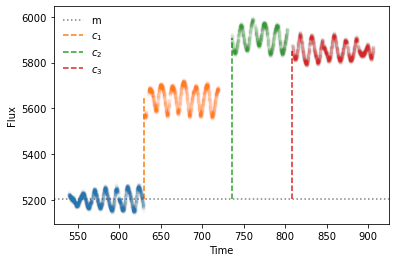

In [2]:
import numpy as np
import matplotlib.pyplot as plt

y_flat = []

qs = sorted(np.unique(tab['quarter']))
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
        y_flat.append(t['flux'])
    else:

        vmin = means[0]
        vmax = meanflux
        
        y_flat.append(t['flux'] - (vmax-vmin))

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False)

y_flat = np.concatenate(y_flat)


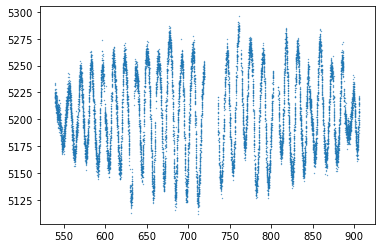

In [16]:
# Plot the corrected light curve
plt.scatter(tab['time'], y_flat, s=0.1)

### As you can see there is some kind of periodic singal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)


<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations.

In [4]:
t = np.array(tab['time']) # THIS IS A NO NO SO BE CAREFUL (overwrighting t and getting confused...)
y = np.array(tab['flux'])
dy = np.array(tab['error'])
q = np.array(tab['quarter'])

### Q2: To implement the full model, read how to use `george`'s modeling protocol:
https://george.readthedocs.io/en/latest/tutorials/model/

In [5]:
skip = 10 # Skip every 10th point in time

In [6]:
from george.modeling import Model
import george

class GPModel(Model):
    parameter_names = ("m", "c1", "c2", "c3")

    def get_value(self, t):
        quarter = [q[i] for i in range(len(t))]
        q_dict = {6:self.m, 7:self.m + self.c1, 8:self.m + self.c2, 9:self.m+self.c3}
        return np.vectorize(q_dict.get)(quarter)

### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots)

Priors are relatively uniformative normal or half Cauchy distributions (for parameters which should definitely not be negative) estimated from the plots.

In [7]:
# Define prior distributions
import scipy.stats as st
A = st.halfcauchy(50, 50)
gamma1 = st.halfcauchy(100, 750) # ?
P = st.halfcauchy(0, 20)
lam = st.halfcauchy(means[0], 750) # ?
# Use means to set prior distribution
m = st.norm(means[0], 750)
c1 = st.norm(means[1]-means[0], 750)
c2 = st.norm(means[2]-means[0], 750)
c3 = st.norm(means[3]-means[0], 750)

# Initialize
A0 = A.rvs(1)[0]
gamma10 = gamma1.rvs(1)[0]
P0 = P.rvs(1)[0]
lam0 = lam.rvs(1)[0]
m0 = m.rvs(1)[0]
c10 = c1.rvs(1)[0]
c20 = c2.rvs(1)[0]
c30 = c3.rvs(1)[0]

In [8]:
print(A0, gamma10, P0, lam0, m0, c10, c20, c30)

312.43089900378055 2035.4258957879897 106.2684279282268 6086.150358801685 5325.228155034228 488.2821811652905 -102.23316747191711 2313.8563260529563


In [9]:
from george import kernels

# Define the kernel

kernel = A0 * (kernels.ExpSine2Kernel(gamma10, np.log(P0)) + kernels.ExpSquaredKernel(lam0))

# Make the model

model = george.GP(kernel, mean=GPModel(m=means[0], c1=means[1]-means[0], c2=means[2]-means[0], c3=means[3]-means[0]))

# Define the log prior

def log_prior(pars):
    
    #        A < 0          P < 0    m0 < 1000
    if pars[0] < 0 or pars[2] < 0 or m0 < 1000:
        return -np.inf
    return 0.0

def lnprob(p):
    model.set_parameter_vector(p)
    return model.log_likelihood(y[::skip], quiet=True) + log_prior(p)

# Do it

pars = model.get_parameter_vector()

model.compute(t[::skip], dy[::skip])

In [10]:
model.get_parameter_names()

('mean:m',
 'mean:c1',
 'mean:c2',
 'mean:c3',
 'kernel:k1:log_constant',
 'kernel:k2:k1:gamma',
 'kernel:k2:k1:log_period',
 'kernel:k2:k2:metric:log_M_0_0')

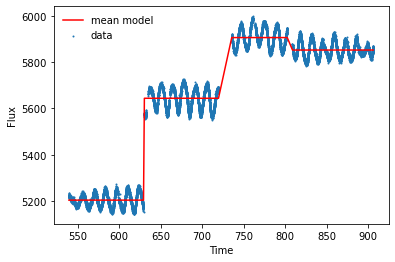

In [11]:
# Done as step 1, plot the result
plt.scatter(t, y, s=1, label='data')
plt.plot(t, GPModel(pars[0],pars[1],pars[2],pars[3]).get_value(t),c='r', label='mean model')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False)

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help

In [12]:
nburnin = 10
nsteps = 30

In [13]:
import emcee

initial = model.get_parameter_vector()
ndim, nwalkers = len(initial), 20
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, nburnin)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, nsteps);

Running burn-in...
Running production...


Text(0.5, 0, 'Step')

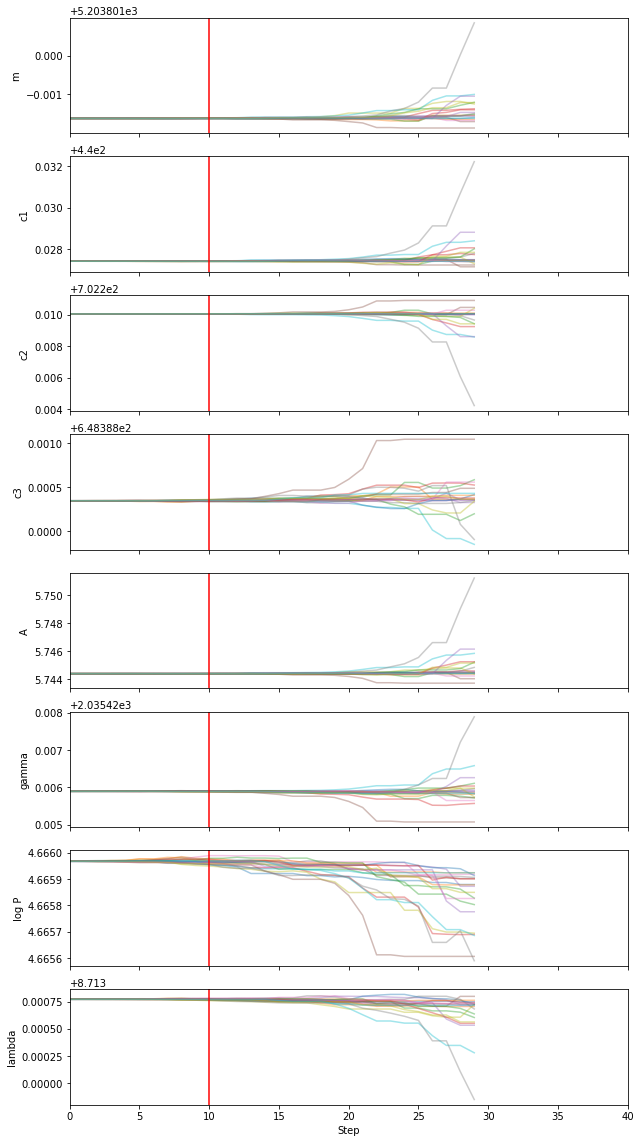

In [14]:
# get the samples
samp = sampler.get_chain()

# make some labels 
labels = ['m', 'c1', 'c2', 'c3', 'A', 'gamma', 'log P', 'lambda']

# make a traceplot 
fig, axs = plt.subplots(nrows=ndim, ncols=1, figsize=(10, 20), sharex=True)
for i in range(ndim):
    ax = axs[i]
    ax.plot(samp[:,:,i], alpha=0.4 )
    ax.set_ylabel(labels[i])
    ax.set_xlim(0, nburnin+nsteps)
    ax.axvline(nburnin, color='red')
ax.set_xlabel('Step')

### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black. 

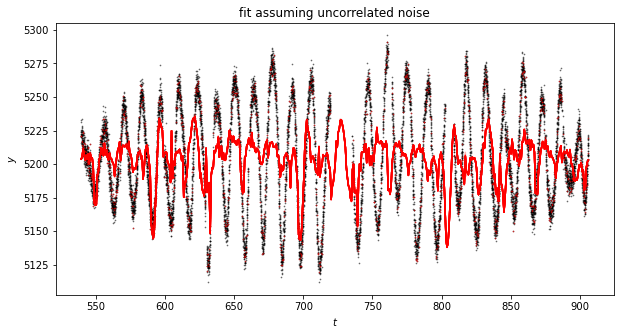

In [15]:
# The positions where the prediction should be computed.
x = np.linspace(np.min(t), np.max(t), 500)

plt.figure(figsize=(10,5))

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    model.set_parameter_vector(s)
    plt.plot(x, model.predict(y_flat[::skip], x, return_cov=False), color='r', alpha=0.3)

plt.scatter(t, y_flat, s = .5, c='k', alpha = 0.5)
plt.scatter(t[::skip], y_flat[::skip], s= .5, c='r', alpha = 0.5)
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.title("fit assuming uncorrelated noise");

Obviously, our model is not converging on a solution! :(